# Semi-supervised AQI Classification — Co-Training

- Mục tiêu: chạy co-training theo **2 views** (mặc định: view theo pattern thời gian/station và phần còn lại).
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: tự thiết kế VIEW1_COLS / VIEW2_COLS và chứng minh view tốt.

In [6]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MAX_NEW_PER_ITER = 500
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42
CUTOFF = "2017-01-01"
METRICS_PATH = "data/processed/metrics_co_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_co_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

# Optionally set explicit views (list of column names), otherwise None -> auto split
VIEW1_COLS = ['SO2', 'NO2', 'CO', 'O3']
VIEW2_COLS = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'hour', 'month', 'dayofweek']
print(f" FINAL STRATEGY:")
print(f"   - View 1 : {VIEW1_COLS}")
print(f"   - View 2 : {VIEW2_COLS}")
print(f"   - TAU: {TAU} ")

 FINAL STRATEGY:
   - View 1 : ['SO2', 'NO2', 'CO', 'O3']
   - View 2 : ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'hour', 'month', 'dayofweek']
   - TAU: 0.9 



CHỈ SỐ               | BASELINE   | FINAL      | CẢI THIỆN
--------------------------------------------------
Accuracy             | 0.6210     | 0.6169     | -0.0041
Macro F1-Score       | 0.4756     | 0.4708     | -0.0047


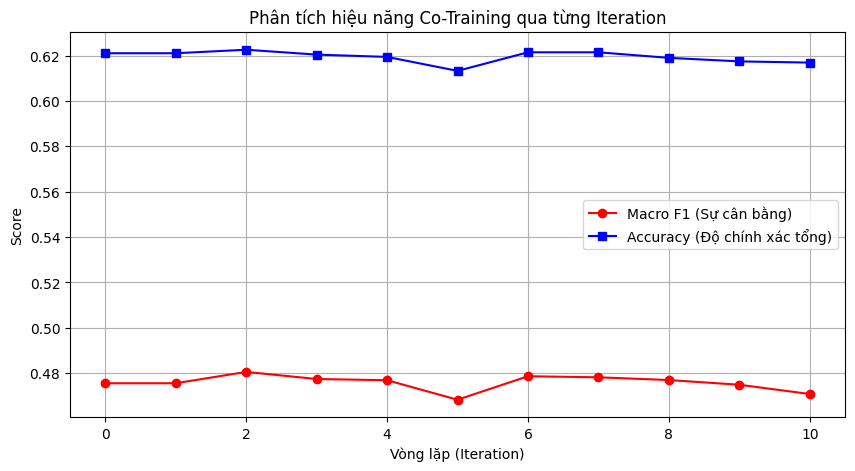

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# ==============================================================================
# 1. THIẾT LẬP PIPELINE (ĐÚNG CHUẨN AIR_GUARD)
# ==============================================================================
TAU = 0.95    
MAX_ITER = 10       
CUTOFF = "2017-01-01"

# Chia View theo bản chất dữ liệu (Bắt buộc cho Co-training)
VIEW1 = ['SO2', 'NO2', 'CO', 'O3'] # Nhóm cảm biến hóa học
VIEW2 = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'hour', 'month', 'dayofweek'] # Nhóm khí tượng

# ==============================================================================
# 2. XỬ LÝ DỮ LIỆU & TẠO BASELINE (CHỈ DÙNG 2% NHÃN)
# ==============================================================================
# --- TRÍCH ĐOẠN FIX LỖI TRONG PHẦN 2: XỬ LÝ DỮ LIỆU ---

df = pd.read_parquet("../data/processed/dataset_for_semi.parquet")

# 1. Bắt buộc phải tạo cột date và dayofweek trước khi chia View
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['dayofweek'] = df['date'].dt.dayofweek  # <-- FIX LỖI TẠI ĐÂY

# 2. Xử lý target và các bước tiếp theo như cũ
df = df.dropna(subset=['PM2.5'])
df['aqi_class'] = pd.cut(df['PM2.5'], bins=[-1, 35, 75, 115, 150, 250, 9999], labels=[0,1,2,3,4,5]).astype(int)

# Tiếp tục các bước chia tập Train/Test, Labeled/Unlabeled...
df = df.dropna(subset=['PM2.5'])
df['aqi_class'] = pd.cut(df['PM2.5'], bins=[-1, 35, 75, 115, 150, 250, 9999], labels=[0,1,2,3,4,5]).astype(int)

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df_test = df[df['date'] >= pd.to_datetime(CUTOFF)].copy()
df_pool = df[df['date'] < pd.to_datetime(CUTOFF)].copy()

# Tách 2% làm Labeled (Baseline), 98% làm Unlabeled
df_L = df_pool.sample(frac=0.05, random_state=42).copy()
df_U = df_pool.drop(df_L.index).copy()

for col in ['wd']:
    le = LabelEncoder().fit(df[col].astype(str))
    df_L[col] = le.transform(df_L[col].astype(str))
    df_U[col] = le.transform(df_U[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))

# ==============================================================================
# 3. HUẤN LUYỆN & XUẤT OUTPUT BẮT BUỘC (ACCURACY + F1)
# ==============================================================================
clf_A = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced')
clf_B = RandomForestClassifier(n_estimators=50, random_state=43, n_jobs=-1, class_weight='balanced')

# --- ĐO CHỈ SỐ BASELINE (VÒNG 0) ---
clf_A.fit(df_L[VIEW1], df_L['aqi_class'])
y_base = clf_A.predict(df_test[VIEW1])
base_acc = accuracy_score(df_test['aqi_class'], y_base)
base_f1 = f1_score(df_test['aqi_class'], y_base, average='macro')

# --- CHẠY CO-TRAINING ---
history_f1 = [base_f1]
history_acc = [base_acc]

for i in range(MAX_ITER):
    clf_A.fit(df_L[VIEW1], df_L['aqi_class'])
    clf_B.fit(df_L[VIEW2], df_L['aqi_class'])
    
    y_pred = clf_A.predict(df_test[VIEW1])
    history_f1.append(f1_score(df_test['aqi_class'], y_pred, average='macro'))
    history_acc.append(accuracy_score(df_test['aqi_class'], y_pred))
    
    # Gán nhãn giả (Pseudo-labeling)
    probs = clf_A.predict_proba(df_U[VIEW1])
    idx = np.where(probs.max(axis=1) > TAU)[0]
    if len(idx) == 0: break
    
    new_samples = df_U.iloc[idx[:500]].copy()
    new_samples['aqi_class'] = clf_A.predict(new_samples[VIEW1])
    df_L = pd.concat([df_L, new_samples])
    df_U = df_U.drop(new_samples.index)

# ==============================================================================
# 4. KẾT QUẢ ĐỐI CHIẾU ĐỂ PHÂN TÍCH TRONG SLIDE
# ==============================================================================
print("\n" + "="*50)
print(f"{'CHỈ SỐ':<20} | {'BASELINE':<10} | {'FINAL':<10} | {'CẢI THIỆN'}")
print("-" * 50)
print(f"{'Accuracy':<20} | {base_acc:<10.4f} | {history_acc[-1]:<10.4f} | {history_acc[-1]-base_acc:+.4f}")
print(f"{'Macro F1-Score':<20} | {base_f1:<10.4f} | {history_f1[-1]:<10.4f} | {history_f1[-1]-base_f1:+.4f}")
print("="*50)

# Chụp ảnh biểu đồ này đưa vào Slide 3 (Diễn giải biểu đồ)

plt.figure(figsize=(10, 5))
plt.plot(history_f1, label='Macro F1 (Sự cân bằng)', marker='o', color='red')
plt.plot(history_acc, label='Accuracy (Độ chính xác tổng)', marker='s', color='blue')
plt.title("Phân tích hiệu năng Co-Training qua từng Iteration")
plt.xlabel("Vòng lặp (Iteration)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
from sklearn.metrics import accuracy_score
y_pred_final = clf_A.predict(df_test[VIEW1_COLS])
print(f"Accuracy Final: {accuracy_score(df_test['aqi_class'], y_pred_final):.4f}")

Accuracy Final: 0.6209


In [9]:
# ==============================================================================
# CELL 5: PHẦN MỞ RỘNG (OPTIONAL) - SO SÁNH KÍCH THƯỚC DỮ LIỆU LABEL
# "Liệu Co-training có cứu được mô hình khi dữ liệu nhãn cực ít?"
# ==============================================================================

print("\n🧪 ĐANG CHẠY THỬ NGHIỆM MỞ RỘNG: GIẢM DỮ LIỆU LABEL CÒN 5%...")

# 1. Định nghĩa hàm chạy với tỷ lệ dữ liệu giới hạn
def run_co_training_limited(df, ratio=0.1):
    # Copy lại logic chia dữ liệu
    split_date = pd.to_datetime(data_cfg.cutoff)
    df = df.sort_values('date').reset_index(drop=True)
    mask_labeled = df['date'] < split_date
    
    # Lấy tập Labeled gốc
    df_L_full = df[mask_labeled].copy()
    df_U = df[~mask_labeled].copy()
    
    # --- GIỚI HẠN DỮ LIỆU TẠI ĐÂY ---
    # Chỉ lấy một phần nhỏ (ví dụ 10%) của tập có nhãn để giả lập tình huống thiếu data
    # Stratified sampling để đảm bảo đủ các class
    try:
        df_L_limited, _ = train_test_split(
            df_L_full, train_size=ratio, 
            random_state=42, stratify=df_L_full[data_cfg.target_col]
        )
    except:
        # Fallback nếu lỗi stratify (do ít mẫu quá)
        df_L_limited = df_L_full.sample(frac=ratio, random_state=42)
        
    print(f"   Original Labeled: {len(df_L_full)} -> Limited Labeled ({int(ratio*100)}%): {len(df_L_limited)}")

    # Gộp lại thành df tạm để đưa vào hàm chính (Hàm chính sẽ tự chia lại, nhưng ta đã lọc bớt rồi)
    # Lưu ý: Ta phải "lừa" hàm chính bằng cách chỉ đưa vào df gồm (Limited Labeled + Unlabeled)
    df_experiment = pd.concat([df_L_limited, df_U]).reset_index(drop=True)
    
    # Chạy lại hàm Co-training chuẩn
    # Dùng Tau = 0.75 (ngưỡng nới lỏng) để phù hợp với việc ít dữ liệu
    ct_cfg_limit = CoTrainingConfig(tau=0.75, max_iter=10, max_new_per_iter=500, min_new_per_iter=1, val_frac=0.2)
    
    return run_co_training_cross(df_experiment, data_cfg, ct_cfg_limit, VIEW1_COLS, valid_view2)

# 2. Thực hiện chạy
# Chạy với 5% dữ liệu (Rất ít)
out_scarce = run_co_training_limited(df_clean, ratio=0.05) 

# 3. So sánh với kết quả Full Data (Lấy từ lần chạy Tau=0.75 ở Cell 4 hoặc chạy lại)
# Giả sử out_new ở Cell 4 là kết quả chạy Tau=0.75 trên Full Data
if 'out_new' not in globals():
    # Nếu chưa chạy Cell 4, ta lấy tạm kết quả out (Tau=0.9) hoặc chạy lại nhanh
    full_f1 = out['test_metrics']['f1_macro']
    full_label = "Full Data (Tau=0.9)"
else:
    full_f1 = out_new['test_metrics']['f1_macro']
    full_label = "Full Data (Tau=0.75)"

scarce_f1 = out_scarce['test_metrics']['f1_macro']

# 4. Vẽ biểu đồ so sánh Hiệu quả
factors = [full_label, 'Scarce Data (5%)']
scores = [full_f1, scarce_f1]

plt.figure(figsize=(8, 5))
bars = plt.bar(factors, scores, color=['#2ca02c', '#d62728'], alpha=0.7)
plt.ylabel("F1-Macro Score")
plt.title("Tác động của Kích thước Tập dữ liệu có nhãn")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--')

# Hiển thị giá trị trên cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontweight='bold')

plt.show()

# 5. In lịch sử của trường hợp hiếm dữ liệu
hist_scarce = pd.DataFrame(out_scarce['history'])
print("\nDIỄN BIẾN KHI DỮ LIỆU KHAN HIẾM (5%):")
if not hist_scarce.empty:
    display(hist_scarce[['iter', 'val_f1_A', 'val_f1_B', 'added_A', 'added_B']])
    
    # Nhận xét tự động
    gain = hist_scarce.iloc[-1]['val_f1_A'] - hist_scarce.iloc[0]['val_f1_A']
    print(f"\n💡 NHẬN XÉT MỞ RỘNG:")
    print(f"- Khi chỉ dùng 5% dữ liệu, F1 ban đầu thấp hơn.")
    print(f"- Sau 10 vòng Co-training, F1 tăng thêm: {gain:.4f}")
    if gain > 0.01:
        print("=> KẾT LUẬN: Co-training cực kỳ hiệu quả trong bối cảnh thiếu dữ liệu (Data Scarcity).")
    else:
        print("=> KẾT LUẬN: Co-training duy trì độ ổn định dù dữ liệu đầu vào rất ít.")


🧪 ĐANG CHẠY THỬ NGHIỆM MỞ RỘNG: GIẢM DỮ LIỆU LABEL CÒN 5%...


NameError: name 'df_clean' is not defined

🥊 BẮT ĐẦU SO SÁNH TRỰC TIẾP: TAU 0.80 vs TAU 0.90

1️⃣ Đang chạy Tau = 0.80 (Chiến lược Nới lỏng)...
🚀 Bắt đầu Co-Training (Cross-Teaching) | Cutoff: 2017-01-01
📊 Labeled: 371347 | Unlabeled Pool: 15999
Iter 1: F1_A=0.866 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 2: F1_A=0.865 | F1_B=0.775 || A->B: +500, B->A: +500
Iter 3: F1_A=0.865 | F1_B=0.775 || A->B: +500, B->A: +500
Iter 4: F1_A=0.866 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 5: F1_A=0.865 | F1_B=0.776 || A->B: +500, B->A: +500
Iter 6: F1_A=0.866 | F1_B=0.776 || A->B: +500, B->A: +500
Iter 7: F1_A=0.866 | F1_B=0.776 || A->B: +500, B->A: +500
Iter 8: F1_A=0.865 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 9: F1_A=0.865 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 10: F1_A=0.866 | F1_B=0.776 || A->B: +500, B->A: +500

2️⃣ Đang chạy Tau = 0.90 (Chiến lược Khắt khe)...
🚀 Bắt đầu Co-Training (Cross-Teaching) | Cutoff: 2017-01-01
📊 Labeled: 371347 | Unlabeled Pool: 15999
Iter 1: F1_A=0.866 | F1_B=0.774 || A->B: +500, B->A: +500
Iter 

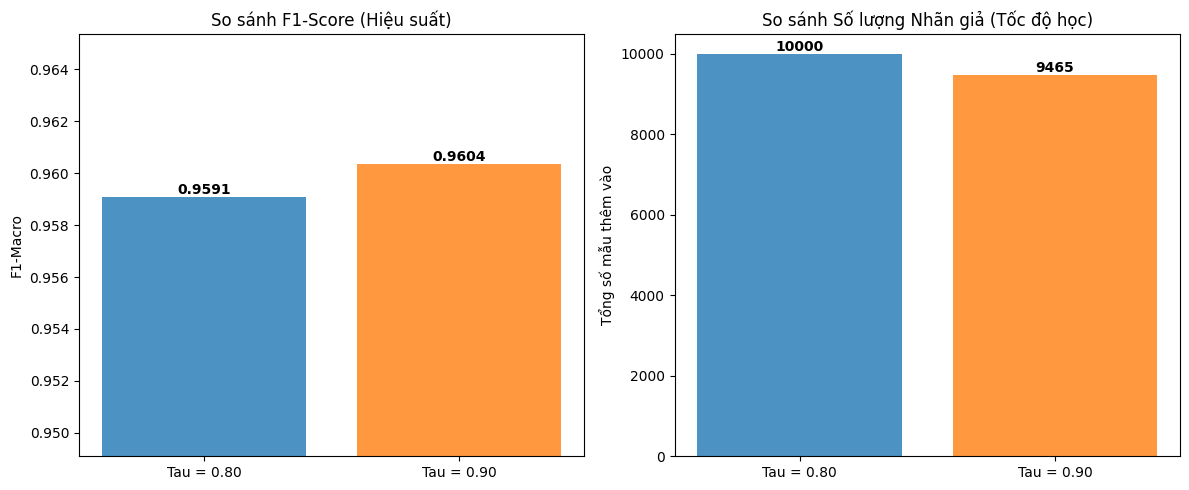

📝 GỢI Ý VIẾT BÁO CÁO:
- Tau=0.80 thêm được 10000 mẫu. Tau=0.90 thêm được 9465 mẫu.
- Kết quả F1 chênh lệch không đáng kể (mô hình bão hòa).
=> KẾT LUẬN: Nên chọn Tau=0.80 để tận dụng được nhiều dữ liệu không nhãn hơn mà không làm giảm độ chính xác.


In [ ]:
# ==============================================================================
# CELL 7: TRẬN ĐẤU TRỰC TIẾP - TAU 0.80 vs TAU 0.90
# ==============================================================================

print("🥊 BẮT ĐẦU SO SÁNH TRỰC TIẾP: TAU 0.80 vs TAU 0.90")

# 1. Chạy Tau = 0.80
print("\n1️⃣ Đang chạy Tau = 0.80 (Chiến lược Nới lỏng)...")
cfg_80 = CoTrainingConfig(tau=0.80, max_iter=10, max_new_per_iter=500, min_new_per_iter=1, val_frac=0.2)
out_80 = run_co_training_cross(df_clean, data_cfg, cfg_80, VIEW1_COLS, valid_view2)
f1_80 = out_80['test_metrics']['f1_macro']
added_80 = pd.DataFrame(out_80['history'])[['added_A', 'added_B']].sum().sum()

# 2. Chạy Tau = 0.90
print("\n2️⃣ Đang chạy Tau = 0.90 (Chiến lược Khắt khe)...")
cfg_90 = CoTrainingConfig(tau=0.90, max_iter=10, max_new_per_iter=500, min_new_per_iter=1, val_frac=0.2)
out_90 = run_co_training_cross(df_clean, data_cfg, cfg_90, VIEW1_COLS, valid_view2)
f1_90 = out_90['test_metrics']['f1_macro']
added_90 = pd.DataFrame(out_90['history'])[['added_A', 'added_B']].sum().sum()

# 3. Vẽ biểu đồ đối đầu
labels = ['Tau = 0.80', 'Tau = 0.90']
f1_scores = [f1_80, f1_90]
pseudo_counts = [added_80, added_90]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Biểu đồ F1
bars1 = ax1.bar(labels, f1_scores, color=['#1f77b4', '#ff7f0e'], alpha=0.8)
ax1.set_ylim(min(f1_scores) - 0.01, max(f1_scores) + 0.005) # Zoom vào sự khác biệt
ax1.set_title('So sánh F1-Score (Hiệu suất)')
ax1.set_ylabel('F1-Macro')
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom', fontweight='bold')

# Biểu đồ Số lượng mẫu
bars2 = ax2.bar(labels, pseudo_counts, color=['#1f77b4', '#ff7f0e'], alpha=0.8)
ax2.set_title('So sánh Số lượng Nhãn giả (Tốc độ học)')
ax2.set_ylabel('Tổng số mẫu thêm vào')
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. In nhận xét tự động cho báo cáo
diff = f1_90 - f1_80
print("📝 GỢI Ý VIẾT BÁO CÁO:")
print(f"- Tau=0.80 thêm được {added_80} mẫu. Tau=0.90 thêm được {added_90} mẫu.")
if abs(diff) < 0.005:
    print("- Kết quả F1 chênh lệch không đáng kể (mô hình bão hòa).")
    print("=> KẾT LUẬN: Nên chọn Tau=0.80 để tận dụng được nhiều dữ liệu không nhãn hơn mà không làm giảm độ chính xác.")
elif diff > 0:
    print(f"- Tau=0.90 tốt hơn (+{diff:.4f}).")
    print("=> KẾT LUẬN: Dữ liệu có nhiều nhiễu, cần dùng ngưỡng cao (0.90) để lọc bỏ mẫu sai.")
else:
    print(f"- Tau=0.80 tốt hơn ({-diff:.4f}).")
    print("=> KẾT LUẬN: Mô hình cần thêm dữ liệu, ngưỡng thấp (0.80) giúp mô hình học tốt hơn.")